In [2]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import Sampler, Session
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
 
backend = service.least_busy(simulator=False, operational=True)
sampler = Sampler(mode=backend, options={"default_shots": 10})
pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend
)

In [3]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

In [4]:
# System Specification
n_qubits = 4
circ = QuantumCircuit(n_qubits)

# Test Circuit
circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)
circ.measure_all()
print(circ)

        ┌───┐                ░ ┌─┐         
   q_0: ┤ H ├──■─────────────░─┤M├─────────
        └───┘┌─┴─┐           ░ └╥┘┌─┐      
   q_1: ─────┤ X ├──■────────░──╫─┤M├──────
             └───┘┌─┴─┐      ░  ║ └╥┘┌─┐   
   q_2: ──────────┤ X ├──■───░──╫──╫─┤M├───
                  └───┘┌─┴─┐ ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────┤ X ├─░──╫──╫──╫─┤M├
                       └───┘ ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════╩══╩══╩══╩═
                                0  1  2  3 


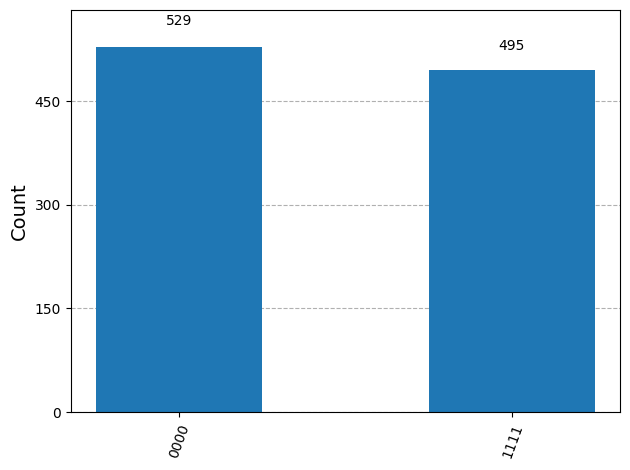

In [32]:
# Ideal simulator and execution
sim_ideal = AerSimulator()
result_ideal = sim_ideal.run(circ).result()
hist = plot_histogram(result_ideal.get_counts(0))
# Guardar la figura com a PNG
hist.savefig("sampler_no_noise_histogram.png", dpi=300, bbox_inches='tight')
hist

In [29]:
# Example error probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['cx', 'u3', 'u2', 'reset', 'u1', 'measure']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


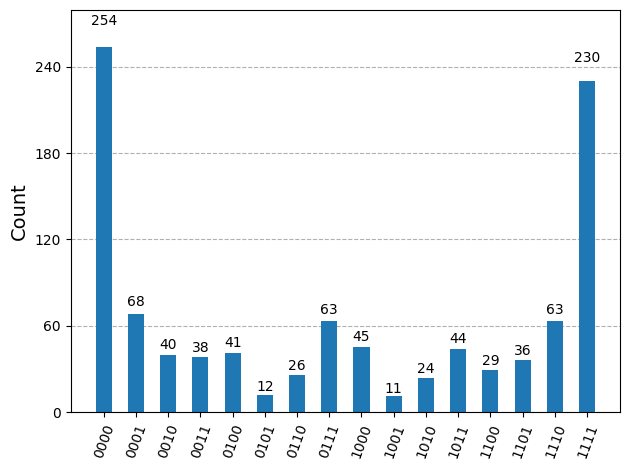

In [31]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_bit_flip)

# Transpile circuit for noisy basis gates
circ_tnoise = transpile(circ, sim_noise)

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
hist = plot_histogram(counts_bit_flip)
hist.savefig("sampler_noise_histogram.png", dpi=300, bbox_inches='tight')
hist

In [15]:
service = QiskitRuntimeService()
 
backend = service.least_busy(simulator=False, operational=True)
sampler = Sampler(mode=backend, options={"default_shots": 1024})
pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend
)

# Transpile circuit for noisy basis gates
circ_tnoise = transpile(circ, backend)

# Run and get counts
result_bit_flip = sampler.run([circ_tnoise]).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_bit_flip)
hist.savefig("sampler_real_histogram.png", dpi=300, bbox_inches='tight')
hist

AttributeError: 'PrimitiveResult' object has no attribute 'get_counts'

{'0000': 491, '1111': 400, '1000': 37, '0100': 2, '0011': 9, '0111': 38, '0001': 7, '0110': 1, '1011': 8, '1110': 7, '1100': 8, '0010': 3, '1101': 9, '0101': 3, '1001': 1}


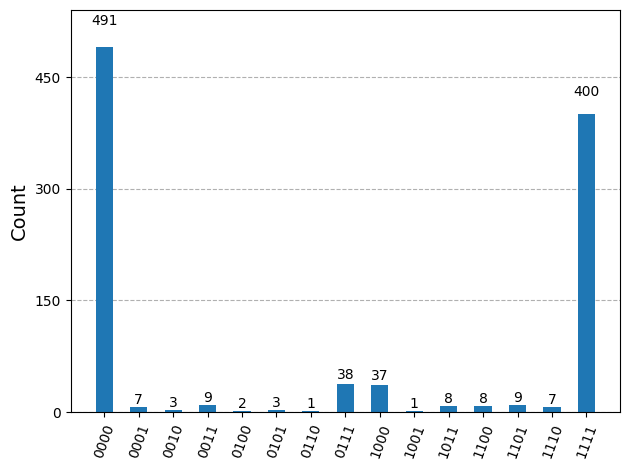

In [28]:
counts = result_bit_flip[0].data.meas.get_counts()
print(counts)
# Plot noisy output
hist = plot_histogram(counts)
hist.savefig("sampler_real_histogram.png", dpi=300, bbox_inches='tight')
hist

In [ ]:
hist.savefig("sampler_real_histogram.png", dpi=300, bbox_inches='tight')